In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import cv2
import random

Data Augmentation & DataLoader

In [14]:
class RobustCNN(nn.Module):
    def __init__(self):
        super(RobustCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
print(device)

cpu


Train/Test Helpers

In [11]:
def train_epoch(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % 200 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]\tLoss: {loss.item():.6f}')
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return avg_loss, accuracy

def test_model(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return all_preds, all_targets

def analyze_and_visualize(all_targets, all_preds):
    print("--- Model Performance Analysis ---")
    print("\nDetailed Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=[str(i) for i in range(10)]))
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Run Training

In [16]:
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001
MODEL_SAVE_DIR = "models"
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, "mnist_robust_cnn.pth")

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.RandomResizedCrop(28, scale=(0.85, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Train Epoch: 1 [0/60000]	Loss: 2.460942
Train Epoch: 1 [12800/60000]	Loss: 0.295247
Train Epoch: 1 [25600/60000]	Loss: 0.408926
Train Epoch: 1 [38400/60000]	Loss: 0.293061
Train Epoch: 1 [51200/60000]	Loss: 0.199032
Epoch 1 Summary: Train Acc: 91.89%, Avg Loss: 0.2976
Train Epoch: 2 [0/60000]	Loss: 0.179306
Train Epoch: 2 [12800/60000]	Loss: 0.363517
Train Epoch: 2 [25600/60000]	Loss: 0.342284
Train Epoch: 2 [38400/60000]	Loss: 0.231377
Train Epoch: 2 [51200/60000]	Loss: 0.248259
Epoch 2 Summary: Train Acc: 95.25%, Avg Loss: 0.1549
Train Epoch: 3 [0/60000]	Loss: 0.224439
Train Epoch: 3 [12800/60000]	Loss: 0.072062
Train Epoch: 3 [25600/60000]	Loss: 0.081854
Train Epoch: 3 [38400/60000]	Loss: 0.115486
Train Epoch: 3 [51200/60000]	Loss: 0.099513
Epoch 3 Summary: Train Acc: 96.07%, Avg Loss: 0.1288
Train Epoch: 4 [0/60000]	Loss: 0.088836
Train Epoch: 4 [12800/60000]	Loss: 0.201096
Train Epoch: 4 [25600/60000]	Loss: 0.069891
Train Epoch: 4 [38400/60000]	Loss: 0.070270
Train Epoch: 4 [51200

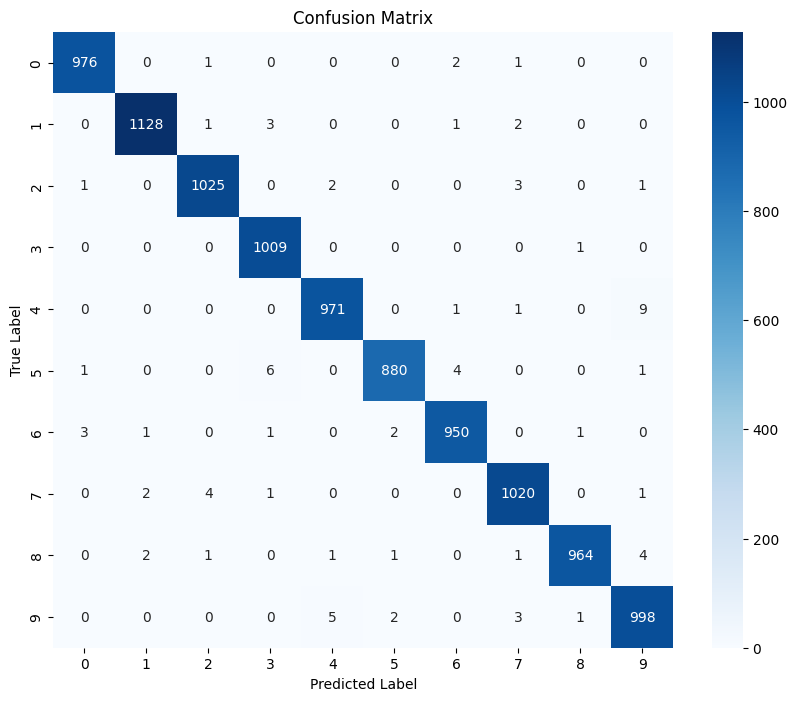

In [19]:
# Initialize Model, Loss, and Optimizer
model = RobustCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, device, train_loader, optimizer, criterion, epoch)
    print(f"Epoch {epoch} Summary: Train Acc: {train_acc:.2f}%, Avg Loss: {train_loss:.4f}")

# Test and Evaluate final model
final_preds, final_targets = test_model(model, device, test_loader, criterion)

# Performance Analysis
analyze_and_visualize(final_targets, final_preds)

In [20]:
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"✅ Model saved to {MODEL_SAVE_PATH}")

✅ Model saved to models\mnist_robust_cnn.pth
